In [68]:
# Toolkit

from importlib import reload
import numpy as np
import networkx as nx
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
import scipy
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# Problem 1a.


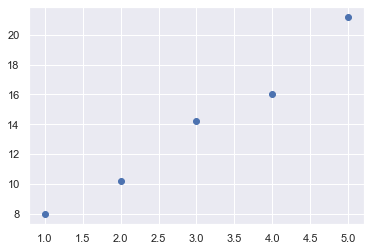

In [50]:
# Here we define the vectors F and l from the problem.


F = np.array([1,2,3,4,5])
l = np.array([7.97,10.2,14.2,16.0,21.2])

# Plotting the data points

plt.scatter(F,l)
plt.show()

In [51]:
# Using Scipy to calculate the values of e and k.
# This is just a sanity check, since we computed e and k by hand in the accompanying write-up.

from scipy.optimize import curve_fit

def f(x, A, B): 
    """Define the straight line"""
    return A*x + B

estimates, estimated_covariances = curve_fit(f, F, l) 

print(f"estimates: {estimates}")

estimates: [3.226 4.236]


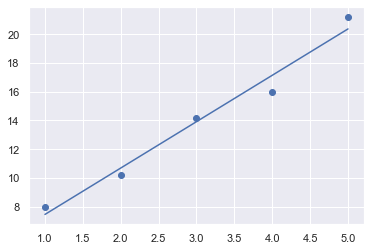

In [52]:
# An alternative library function calculation of the least squares equation.
# Here, we also plot the results.

from numpy.polynomial.polynomial import polyfit

b, m = polyfit(F, l, 1)

plt.scatter(F,l)
plt.plot(F, b + m * F, '-')
plt.show()

# Problem 1b.

In [53]:
# We now compute the values of e and k using SVD.

stub = np.array([1,1,1,1,1])

# build a rank 1 matrix from vector F
F_prime = np.vstack((stub, F)).T

# store rank and ncols
n = F_prime.shape[1]
r = np.linalg.matrix_rank(F_prime)

# compute SVD
U, sigma, VT = np.linalg.svd(F_prime, full_matrices=False)

# build inverted matrix sigma^-
# one over each poitive singular value
sigma_1 = np.diag(np.hstack([1/sigma[:r], np.zeros(n-r)]))

# find V
V = VT.T

# compute psuedo inverse
X_1 = V.dot(sigma_1).dot(U.T)

# compute solution
w = X_1.dot(l)
print(w)

[4.236 3.226]


# Problem 2.

In [74]:
# Note: In this problem, several of the trickier bits of coding are due to Cooper Stansbury.
# For example, I owe the coding of the algorithms themselves to him! 

# We first define some basic functions to load and plot the data.

def load_data(filepath="/Users/Calum/Downloads/data_mat.csv"):
    """A function to load the data matrix
    
    Args:
        - filepath (str): filepath of the data matrix
        
    Returns
        mat (2d np.array): a matrix with the data
    """
    return np.genfromtxt(filepath, delimiter=',')

def plot_heatmap(arr, cmap="coolwarm", **kwargs):
    """ A function to plot a heatmap.
    Args:
        - arr (np.array): a 2d array
        - cmap (string): color map to pass to sns
        - **kwargs (dict): additional keyword arguments to pass 
            the figure building functions
    Returns:
        - ax (plt.axes._subplots.AxesSubplot)
    """
    fig = build_fig(**kwargs)
    sns.heatmap(arr, cmap=cmap)

/Users/Calum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """


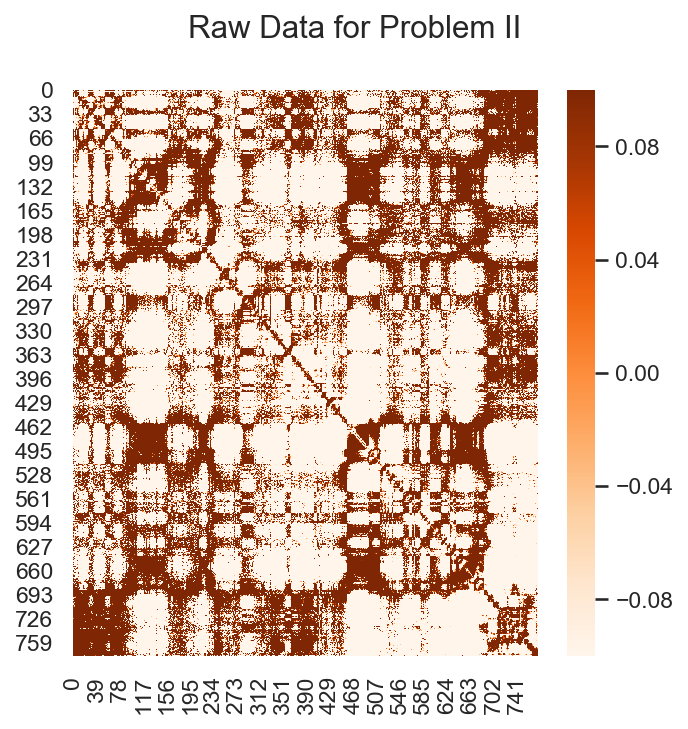

In [78]:
# Now we plot the data using the above-defined function.
# N.B., if you're running this file on your computer, you should replace the filepath I've included here. 

W = load_data(filepath="/Users/Calum/Downloads/data_mat.csv")
plot_heatmap(np.log2(W), size=(5,5), dpi=150, 
             title="Raw Data for Problem II",
             cmap="Oranges")

In [89]:
# Now we define our three clustering algorithms

def compute_D(W):
    """A function to compute D, given W
    
    Args:
        - W (2d np.array): adjency matrix
        
    Returns:
        - D (2d dioagonal np.array)
    """
    D = np.zeros(W.shape)
    
    for i in range(0, len(W)):
        D[i,i] = np.sum(W[:,i])
        
    return D

def normlize_rows(eigenvectors):
    """A fucntion to normalize eigenvectors
    row-wise across n eigenvectors
    
    Args:
        - eigenvectors (np.array): the n eigenvectors
    
    Returns:
        - T (np.array): eigenvectors normalized
    """
    T = np.zeros(eigenvectors.shape)
    for idx, row in enumerate(eigenvectors):
        T[idx] = abs(row / np.linalg.norm(row, ord=1))
    return T

def sp_clustering_1(k=3):
    """A function to compute the spectral
    clustering using the first method.
    
    1. Get adjencency matrix W
    2. Compute degree matrix D
    3. Compute L (unnormalized) 
    4. Get first k eigenvectors from L
    5. Let k eigenvectors be columns of U
    6. TODO
    7. Cluster U using k-means
    
    Args:
        - k (int): the number of clusters
        
    Returns:
        - clustrer labels
    """
    A = load_data(filepath="/Users/Calum/Downloads/data_mat.csv")
    D = compute_D(A)
    L = D - A
    
    w, v = np.linalg.eig(L)
    
    v = v[:,0:k]
    
    cluster = KMeans(n_clusters=k).fit(v)
    return cluster.labels_, v


def sp_clustering_2(k=3):
    """A function to compute the spectral
    clustering using the first method.
    
    1. Get adjencency matrix W
    2. Compute degree matrix D
    3. Compute L (unnormalized) 
    4. Get first k eigenvectors from the generalized 
        `solution Lu = lambda Du`
    5. Let k eigenvectors be columns of U
    6. TODO
    7. Cluster U using k-means
    
    Args:
        - k (int): the number of clusters
        
    Returns:
        - clustrer labels
    """
    A = load_data(filepath="/Users/Calum/Downloads/data_mat.csv")
    D = compute_D(A)
    L = D - A
    w, v = scipy.linalg.eigh(L, D, eigvals_only=False)
    v = v[:,0:k]
    
    cluster = KMeans(n_clusters=k).fit(v)
    return cluster.labels_, v


def sp_clustering_3(k=3):
    """A function to compute the spectral
    clustering using the first method.
    
    1. Get adjencency matrix W
    2. Compute degree matrix D
    3. Compute notmalized L :
        L = D^-1/2 L D^-1/2 
    5. Let k eigenvectors be columns of U J
    6. Normlize rows of J
    7. Cluster J using k-means
    
    Args:
        - k (int): the number of clusters
        
    Returns:
        - clustrer labels
    """
    A = load_data(filepath="/Users/Calum/Downloads/data_mat.csv")
    _L = scipy.sparse.csgraph.laplacian(A, normed=True) 
    w, v = scipy.linalg.eigh(_L)
    _v = normlize_rows(v[:,0:k])
    
    cluster = KMeans(n_clusters=k).fit(_v)

    return cluster.labels_, _v

In [90]:
# Here, we perform speed tests 

labels_1, eigenvectors_1 = sp_clustering_1()